## Advanced Lane Finding Project

The goals / steps of this project are the following:

* [Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.](#jump1)
* [Apply a distortion correction to raw images.](#jump2)
* [Use color transforms, gradients, etc., to create a thresholded binary image.](#jump3)
* [Apply a perspective transform to rectify binary image ("birds-eye view").](#jump4)
* [Detect lane pixels and fit to find the lane boundary.](#jump5)
* [Determine the curvature of the lane and vehicle position with respect to center.](#jump6)
* [Warp the detected lane boundaries back onto the original image.](#jump7)
* [Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.](#jump8)

## Step 0 : import packages

In [64]:
# -*- coding=UTF-8 -*-
import numpy as np
import os
import cv2
import glob
import pickle 
import matplotlib.pyplot as plt
import matplotlib.image as mping

%matplotlib inline

## <span id="jump1">Step 1: Compute the camera calibration matrix and distortion coefficients .</span>    
The camera calibration matrix was got in the [**Get-CameraMatrix-UndistortMatrix.ipynb**](./Get-CameraMatrix-UndistortMatrix.ipynb) file. Please run it at first to get camera matrix. Now just to load it.

In [19]:
npzfile = np.load("camera_matrix.npz")
mtx = npzfile['mtx']
dist = npzfile['dist']

### Examples of undistorted image

In [20]:
def imgUndistort(img, mtx=mtx, dist=dist):
    """
    Undistort image
    
    Arguments:
        img: source image
        mtx: camera internal matrix
        dist: distortion coefficients
    """
    return cv2.undistort(img, mtx, dist, None, mtx)


def show_undistort_image(img, mtx, dist, bBGR=False):
    """
    Comparely show origin image and undistort image
    
    Arguments:
        img: source image
        mtx: camera internal matrix
        dist: distortion coefficients
        bBGR: bool value, if BGR channel order
    """
    imgRGB = img
    if bBGR:
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    img_undistort =  imgUndistort(imgRGB, mtx, dist)
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.title("original Image", fontsize=16)
    plt.imshow(imgRGB)
    
    plt.subplot(1,2,2)
    plt.title("Undistorted Image", fontsize=16)
    plt.imshow(img_undistort)

    
def showImages(images, label=None, cols=3, figsize=(14,14), ticksshow=True):
    """
    Show cols images per colum
    
    Arguments:
        images: image list or array-like
        label: image label, list
        cols: the number of images per colums
        ticksshow: whether show ticks, bool value
    """
    rows = (len(images) + cols - 1)//cols 
    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        
        # use gray scale color map if there is only one channel   
        imgShape = image.shape
        
        cmap = None       
        if len(imgShape) == 2: 
            cmap = "gray"
        elif  imgShape[2] == 1:
            image = image[:,:,0]
            cmap = "gray"
        
        plt.imshow(image, cmap=cmap)
        if label != None and label[i] != None:
            plt.title(label[i], fontsize=12)
            
        if not ticksshow:
            plt.xticks([])
            plt.yticks([])
            
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

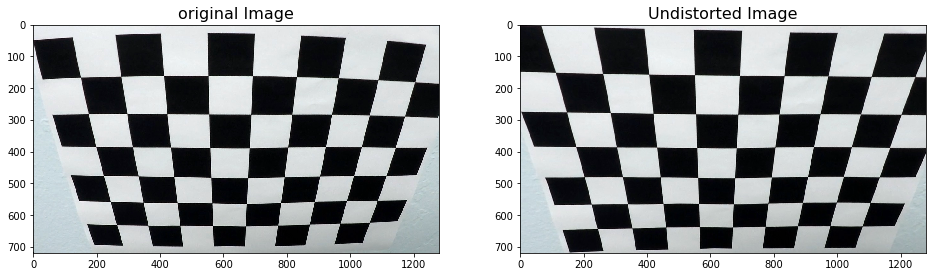

In [21]:
show_undistort_image(cv2.imread("camera_cal/calibration2.jpg"),mtx,dist)

## <span id="jump2">Step 2: Apply a distortion correction to raw images.</span>    

In [22]:
testImageList = glob.glob('test_images/*.jpg')
testImages = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in testImageList]
images_undistort = list(map(imgUndistort, testImages))

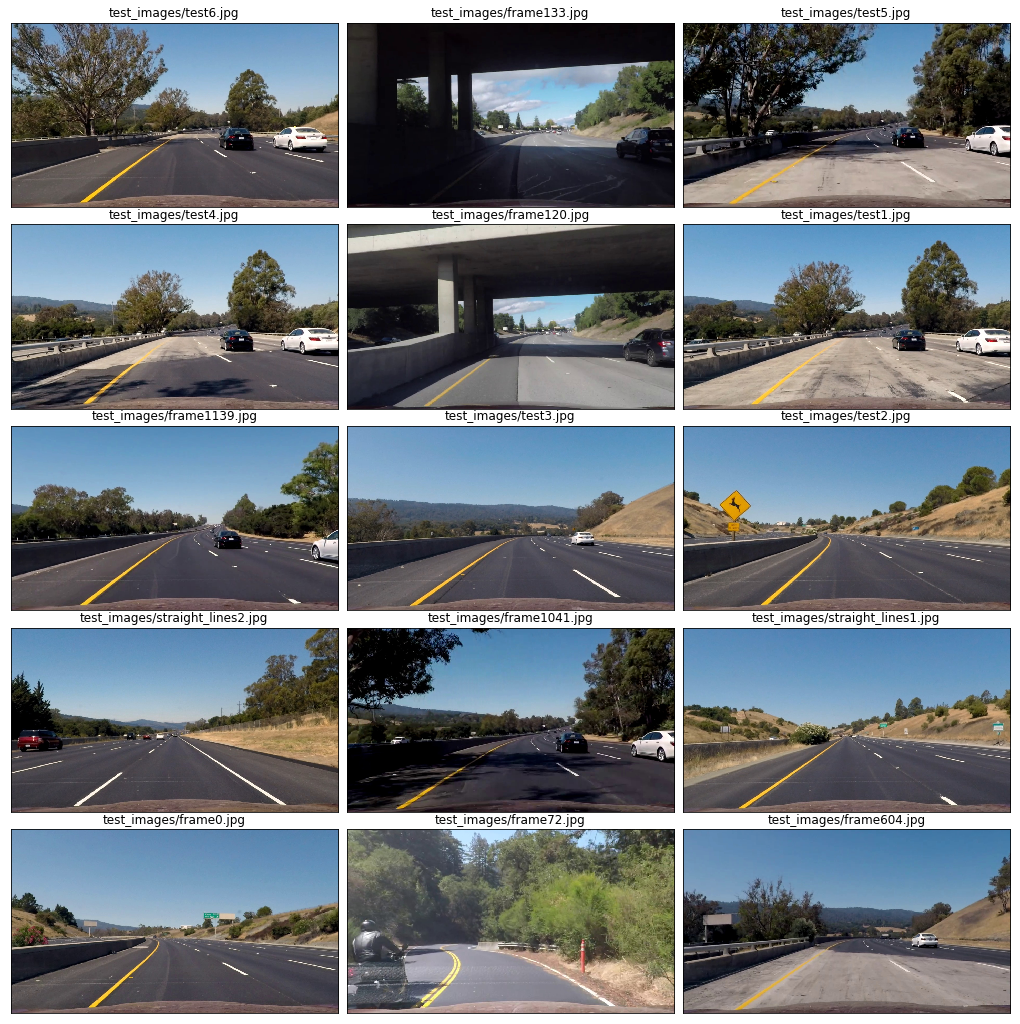

In [23]:
# for filename in testImageList:
#     img = cv2.imread(filename)
#     imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     show_undistort_image(imgRGB, mtx, dist)

showImages(images_undistort, testImageList, cols=3, figsize=(14,14), ticksshow=False)

## <span id="jump3">Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.</span>   

---
### Color transforms: HSL, HSV and Lab color space in split channels

In [24]:
def splitChannels(img):
    """
    Split image into three channels in HSV, HLS and Lab separately
    
    Arguments:
        img: source image
    """
    channel_images=[]
    channel_images_label=[]
    
    #origin RGB image
    channel_images.append(img)
    channel_images_label.append('Original Image')
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    channel_images.append(gray)
    channel_images_label.append('Gray Image')  
    
    grayequalizeHist = cv2.equalizeHist(gray) 
    channel_images.append(grayequalizeHist)
    channel_images_label.append('EqualizeHist Gray Image') 
    
    #HLS image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    channel_images.append(h)
    channel_images_label.append('HLS: H Channel Image') 
    channel_images.append(l)
    channel_images_label.append('HLS: L Channel Image') 
    channel_images.append(s)
    channel_images_label.append('HLS: S Channel Image') 
    
    #HSV image
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    channel_images.append(h)
    channel_images_label.append('HSV: H Channel Image') 
    channel_images.append(s)
    channel_images_label.append('HSV: S Channel Image') 
    channel_images.append(v)
    channel_images_label.append('HSV: V Channel Image') 
    
    #Lab image
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    l = lab[:,:,0]
    a = lab[:,:,1]
    b = lab[:,:,2]
    channel_images.append(l)
    channel_images_label.append('Lab: L Channel Image') 
    channel_images.append(a)
    channel_images_label.append('Lab: a Channel Image') 
    channel_images.append(b)
    channel_images_label.append('Lab: b Channel Image') 
    
    return channel_images,channel_images_label

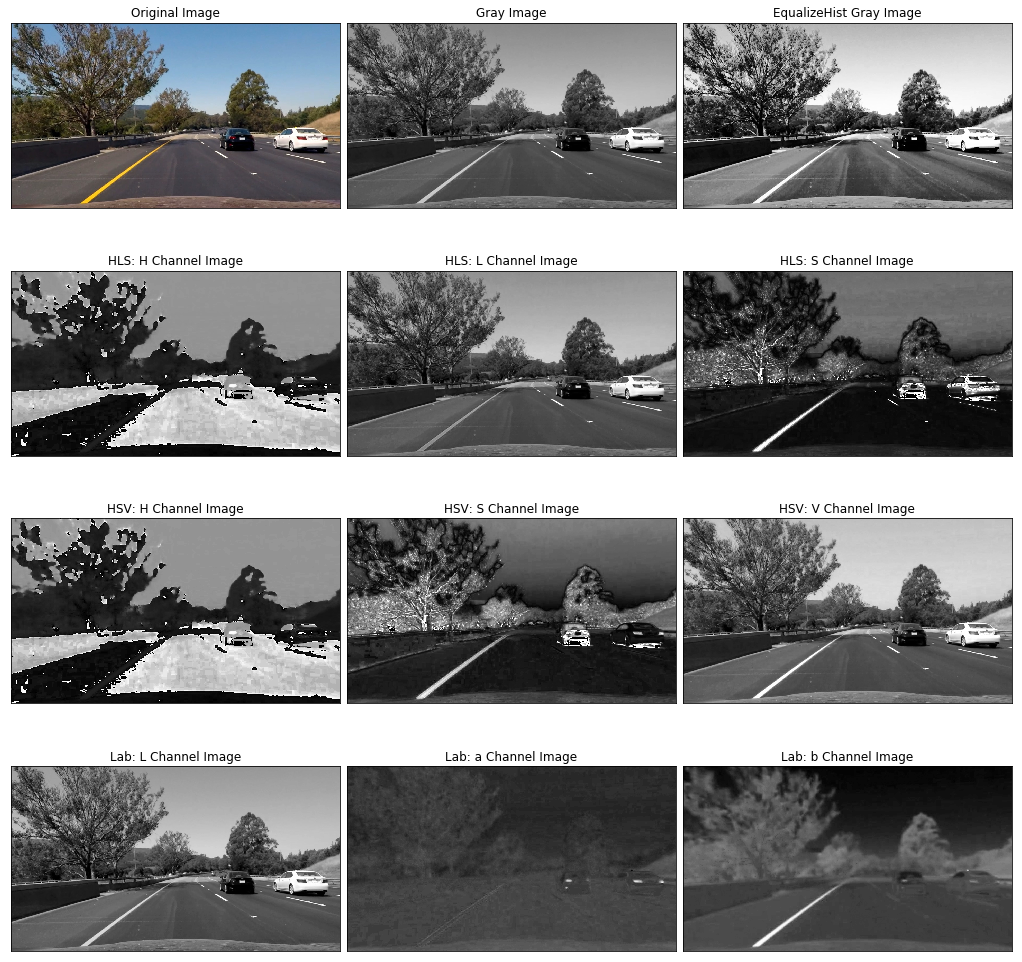

In [25]:
testImgRGB = cv2.cvtColor(cv2.imread(testImageList[0]), cv2.COLOR_BGR2RGB)
testImg_undistort =  cv2.undistort(testImgRGB, mtx, dist, None, mtx)
images, label = splitChannels(testImg_undistort)

showImages(images, label, figsize=(14,14), ticksshow=False)

### Define color thresh functions

In [117]:
def color_thresh(img, threshLow, threshHigh, colorSpace="HSV", oneChannel=None):
    """Convert color space to another, return binary image
    
    Arguments:
        img: RGB channel order
        colorSpace: "RGB", "HSV", "HSL"
        threshLow: if oneChannel=None (channel1, channel2, channel3) tuple, else single value
        threshHigh: if oneChannel=None (channel1, channel2, channel3) tuple, else single value
        oneChannel: appoint one channel
    """
    dstImg = np.zeros_like(img)
    
    if colorSpace == "HSV":
        dstImg = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
    if colorSpace == "HSL":
        dstImg = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    if colorSpace == "Lab":
        dstImg = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        
    if colorSpace == "RGB":
        dstImg = img
   
    # Return color select mask
    binary_output = np.zeros((img.shape[0], img.shape[1]))
    
    if oneChannel:
        oneChannelImage = dstImg[:,:,oneChannel]
        if colorSpace == "HSV":
            oneChannelImage = cv2.equalizeHist(oneChannelImage)
        binary_output[(oneChannelImage >= threshLow) & (oneChannelImage <= threshHigh)] = 1
    else:
        binary_output[(dstImg[:,:,0] >= threshLow[0]) & (dstImg[:,:,0] <= threshHigh[0]) & (dstImg[:,:,1] >= threshLow[1])  & (dstImg[:,:,1] <= threshHigh[1])  & (dstImg[:,:,2] >= threshLow[2]) & (dstImg[:,:,2] <= threshHigh[2])] = 1
                 
    return binary_output

### Yellow Lane filtered by Lab color space in b Channel

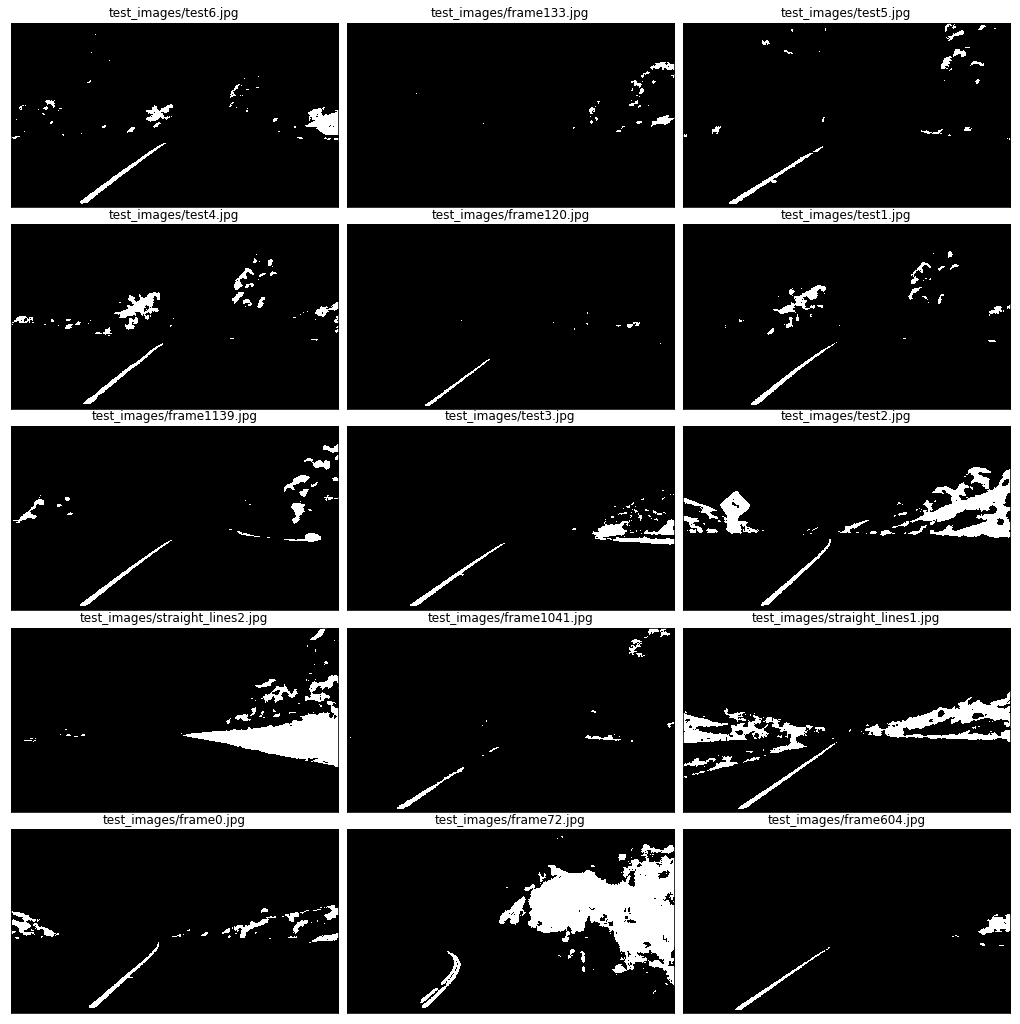

In [118]:
color_binary = list(map(lambda img: color_thresh(img, 150, 255, colorSpace="Lab", oneChannel=2), images_undistort))

showImages(color_binary, testImageList, ticksshow=False)

### White Lane filtered by HSL color space in Lightness Channel

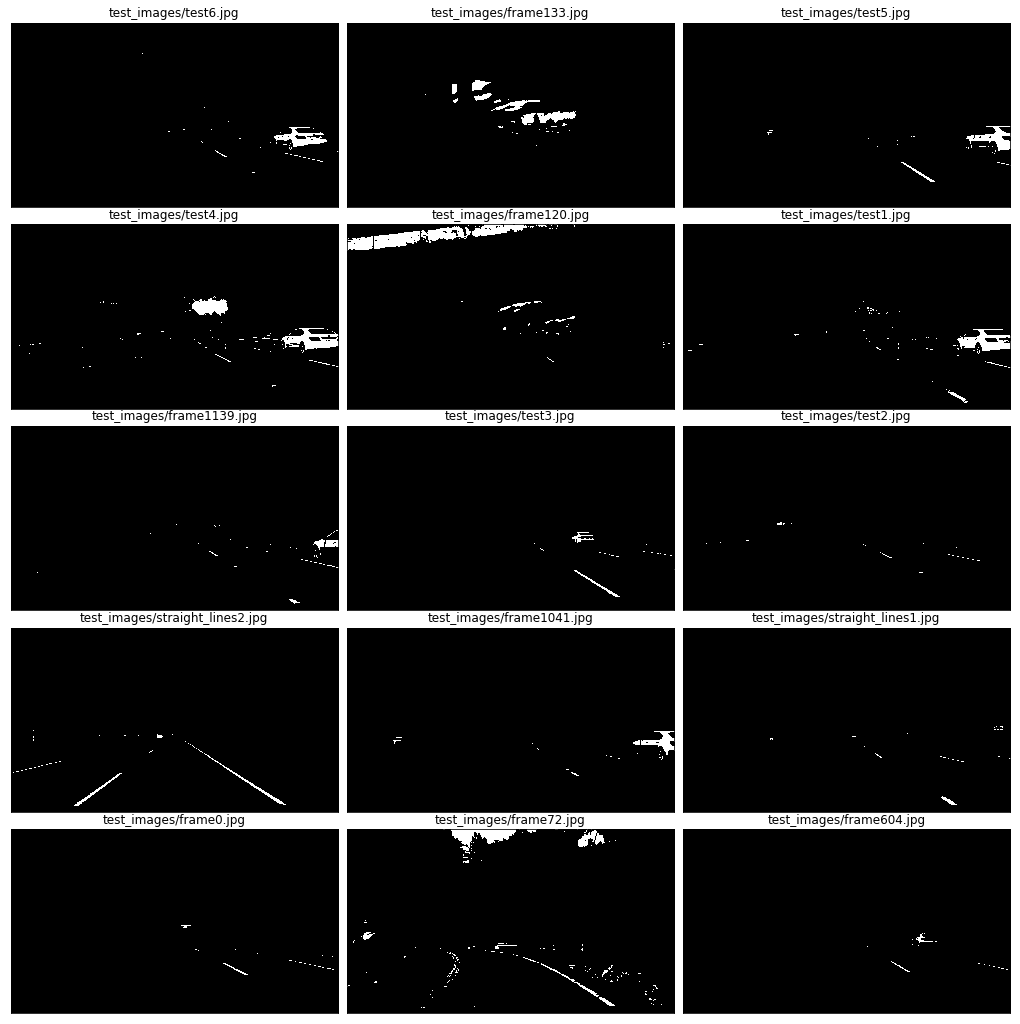

In [121]:
color_binary = list(map(lambda img: color_thresh(img, 210, 255, colorSpace="HSL", oneChannel=1), images_undistort))

showImages(color_binary, testImageList, ticksshow=False)

### Road Area Selected by HSV color space in Value Channel

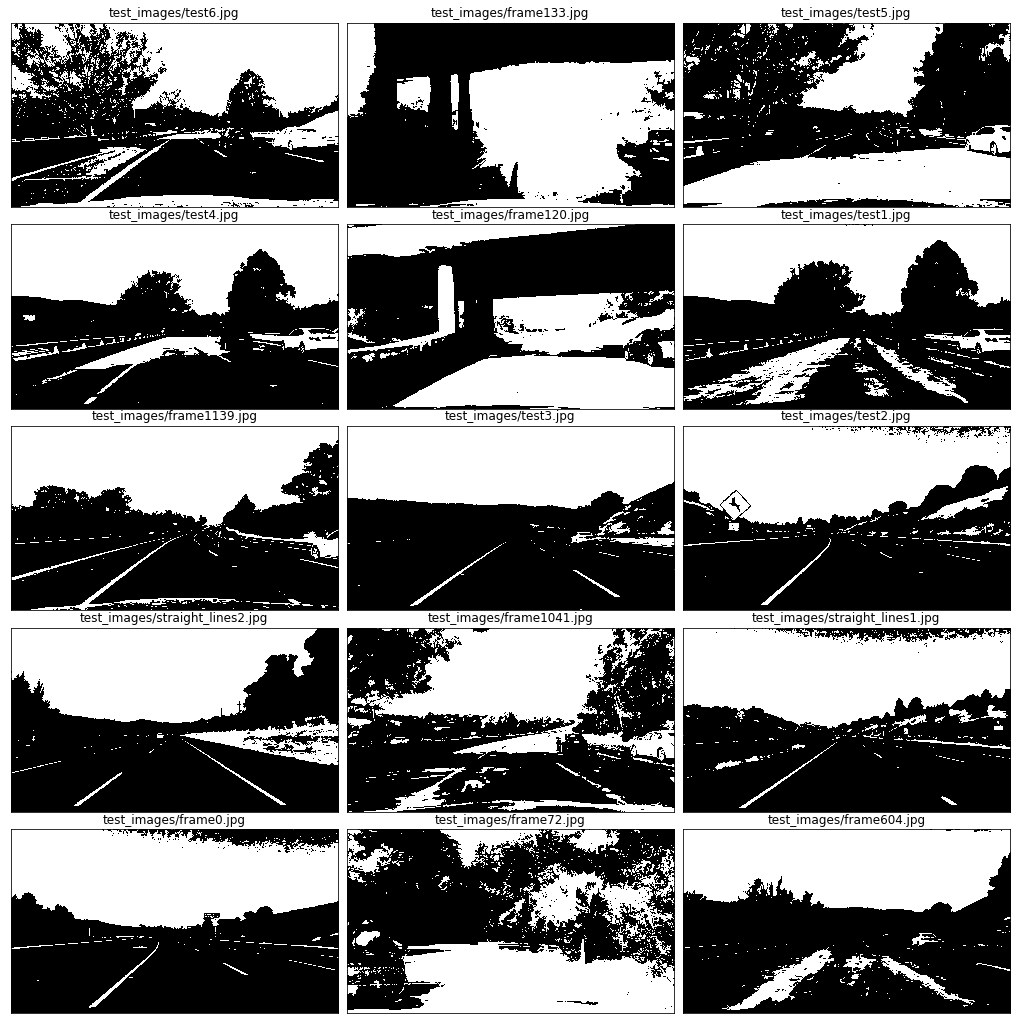

In [122]:
color_binary = list(map(lambda img: color_thresh(img, 145, 255, colorSpace="HSV", oneChannel=2), images_undistort))

showImages(color_binary, testImageList, ticksshow=False)

### Define Gradient and sobel functions

In [52]:
def sobel_x(img, sobel_kernel=3, min_thresh = 20, max_thresh =100, colorSpace="HSL"):
    """
    Filter out horizontal noise, return binary image
    
    Arguments:
        img: source image
        colorSpace: "RGB", "HSL", "HSV"
        sobel_kernel: kernel size
        min_thes: min thresh
        max_thes: max thresh
    """
    dstImg = np.zeros_like(img)
    
    if colorSpace == "HSV":
        dstImg = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
    if colorSpace == "HSL":
        dstImg = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        
    if colorSpace == "RGB":
        dstImg = img
    
    #Channels L and S from HLS
    sobelx1 = cv2.Sobel(dstImg[:,:,1], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelx2 = cv2.Sobel(dstImg[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelx1 = np.uint8(255*sobelx1/ np.max(sobelx1))
    scaled_sobelx2 = np.uint8(255*sobelx2/ np.max(sobelx2))

    # Create a binary mask where thresholds are met
    binary_outputx1 = np.zeros_like(scaled_sobelx1)
    binary_outputx1[(scaled_sobelx1 >= min_thresh) & (scaled_sobelx1 <= max_thresh)] = 1

    binary_outputx2 = np.zeros_like(scaled_sobelx2)
    binary_outputx2[(scaled_sobelx2 >= min_thresh) & (scaled_sobelx2 <= max_thresh)] = 1

    binary_output = np.zeros_like(scaled_sobelx1)
    binary_output[(binary_outputx1 ==1) | (binary_outputx2 ==1)]=1
    
    return binary_output

def sobel_thresh(img, orientation='x', sobel_kernel=5, min_thresh=20, max_thresh=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.equalizeHist(gray)
    
    if orientation == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    
    if orientation == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    scaled_sobel = np.uint8(255*abs_sobel/ np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= min_thresh) & (scaled_sobel <= max_thresh)] = 1
    
    return binary_output


def gradMag_thresh(img, sobel_kernel=3, gradmag_thresh=(50, 255)): 
    """
    Calulate magnitude of gradient, return binary image
    
    Arguments:
        img: source image
        sobel_kernel: kernel size
        gradmag_thresh: magnitude of gradient threshold
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude of gradient
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
       
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= gradmag_thresh[0]) & (scaled_sobel <= gradmag_thresh[1])] = 1

    return binary_output


#Direction threshold
def direction_thresh(img, sobel_kernel=3, thresh=(0.7, np.pi/2)):
    """
    Using angle thesh
    
    Arguments:
        img: source image
        sobel_kernel: kernel size
        thresh: angle rangement
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddirection = np.arctan2(abs_sobely, abs_sobelx) 

    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddirection)
    binary_output[(absgraddirection >= thresh[0]) & (absgraddirection <= thresh[1])] = 1

    return binary_output

#Both Magnitude and direction threshold
def gradMag_direction_thresh(img, sobel_kernel=3, mag_thresh=(50, 255), dir_thresh=(0.7, np.pi/2)):
    """
    Both using Magnitude of gradient and angle direction thresh, return binary image
    
    Arguments:
        img: source image
        sobel_kernel: kernel size
        mag_thresh: magnitude of gradient thresh
        dir_thresh: direction thresh
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude of gradient
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    #Calculate angle
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
       
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1]) & (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1]) ] = 1

    return binary_output

## Examples of gradient  thresholds

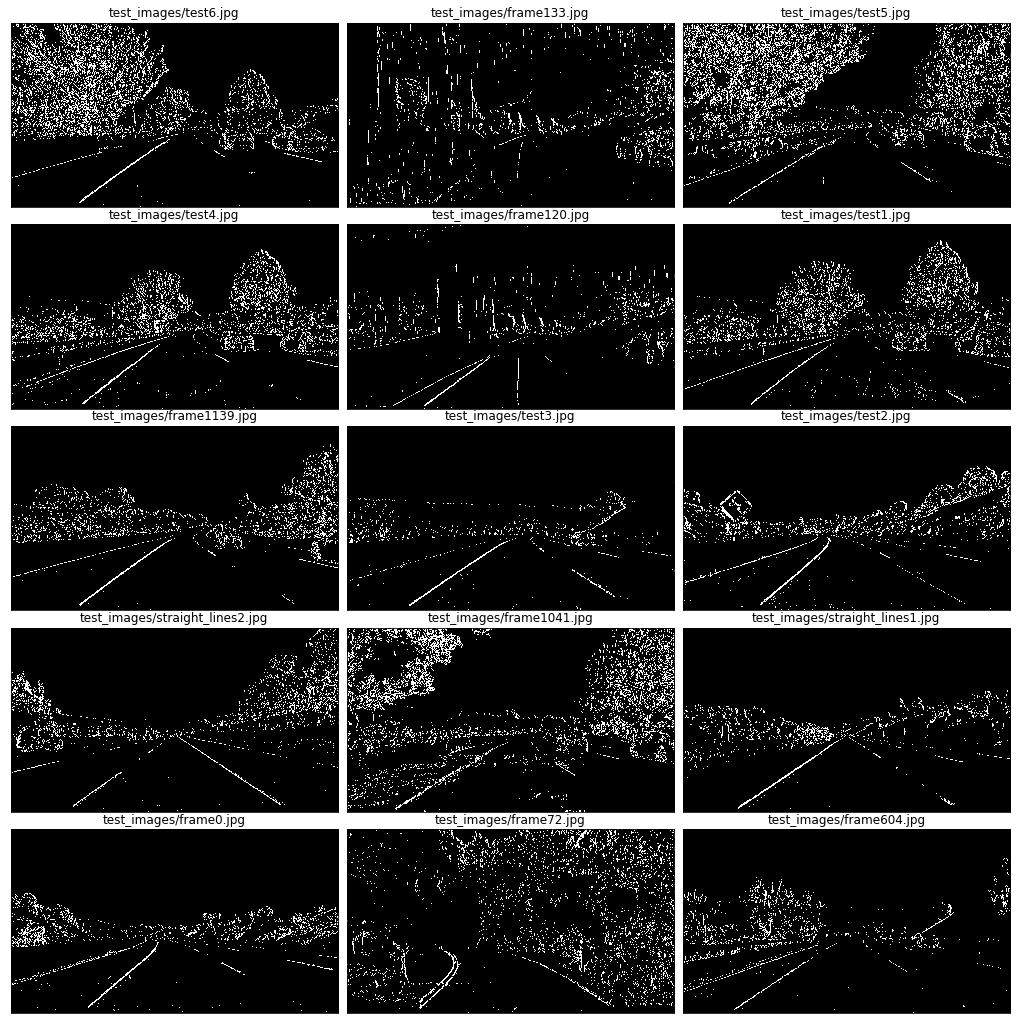

In [99]:
gradient_binary = list(map(sobel_x, images_undistort))

showImages(gradient_binary, testImageList, ticksshow=False)

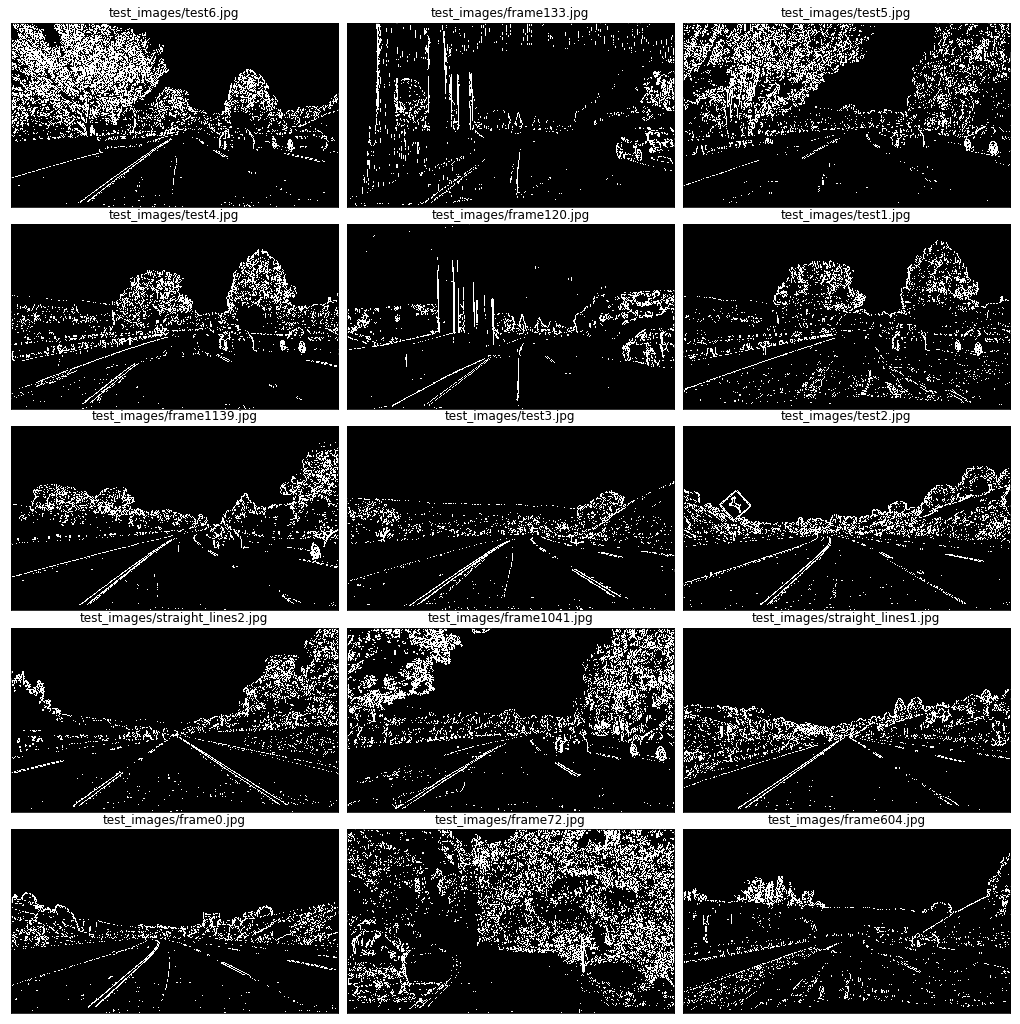

In [100]:
gradient_binary = list(map(sobel_thresh, images_undistort))

showImages(gradient_binary, testImageList, ticksshow=False)

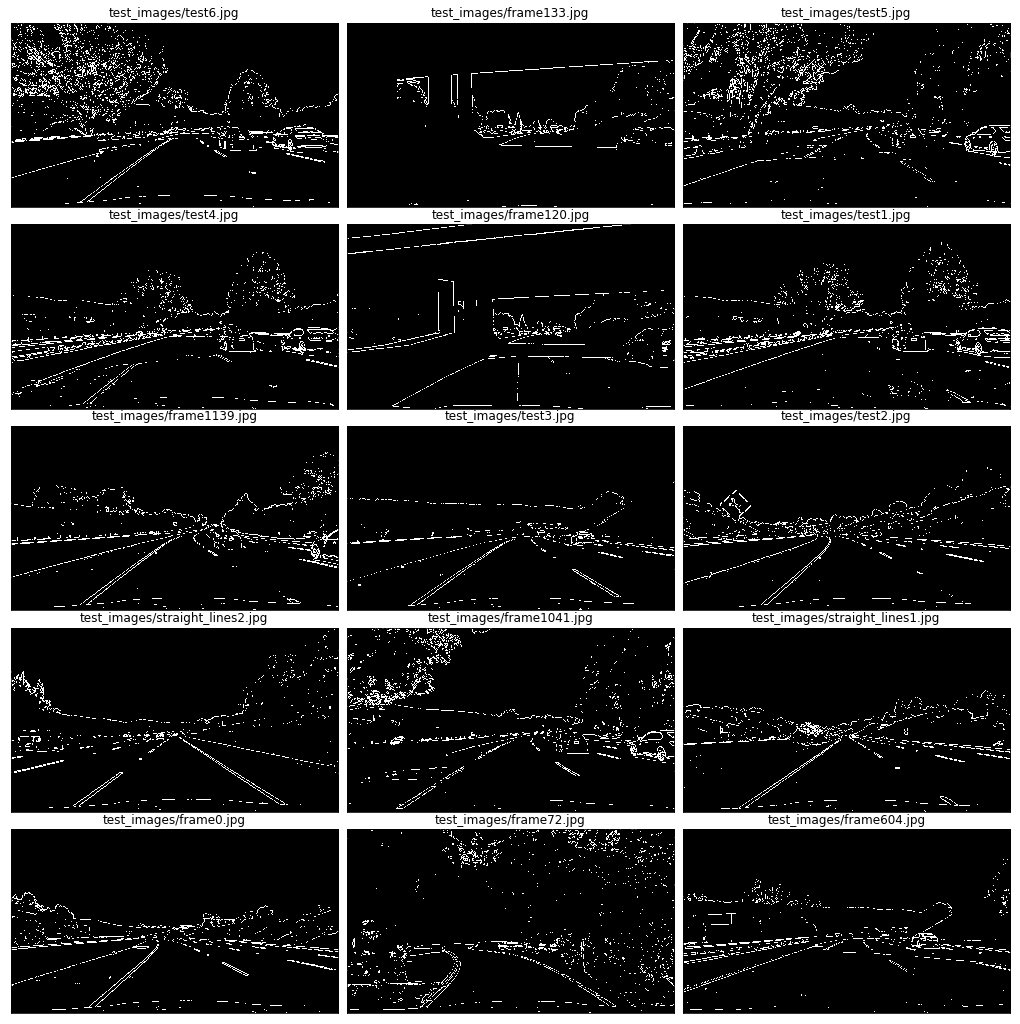

In [101]:
gradient_binary = list(map(gradMag_thresh, images_undistort))

showImages(gradient_binary, testImageList, ticksshow=False)

In [109]:
def pipeline(img):
    sobel_thresh_binary = sobel_thresh(img)
    hsv_thresh_binary = color_thresh(img, 145, 255, colorSpace="HSV", oneChannel=2)
    hsl_thresh_binary = color_thresh(img, 210, 255, colorSpace="HSL", oneChannel=1)
    lab_thresh_binary = color_thresh(img, 150, 255, colorSpace="Lab", oneChannel=2)

    combined_binary = np.zeros_like(sobel_thresh_binary)   
    combined_binary[ ((sobel_thresh_binary == 1) & (hsv_thresh_binary == 1)) |(hsl_thresh_binary == 1)| (lab_thresh_binary == 1)] = 1
    
    return combined_binary

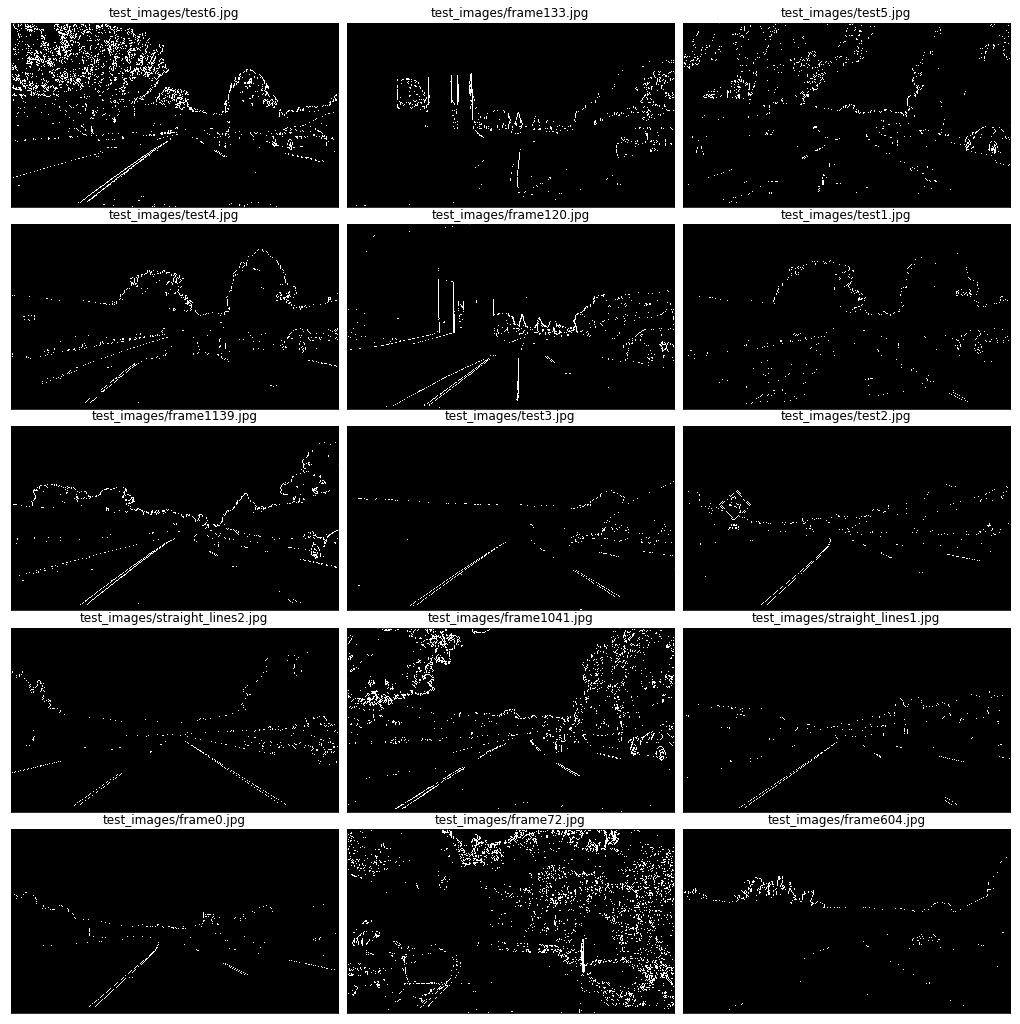

In [108]:
filted_binary = list(map(pipeline, images_undistort))
showImages(filted_binary, testImageList, ticksshow=False)

## <span id="jump4">Step 4: Apply a perspective transform to rectify binary image ("birds-eye view").</span>
---
### Perspective Transformed View Point

In [66]:
def perspective_transform_matrix(img, show_debug=False):
    img_size = img.shape[:2][::-1]
    src = np.float32(\
    [[(img_size[0] / 2) - 75, img_size[1] / 2 + 110],\
     [((img_size[0] / 6) - 10), img_size[1]],\
     [(img_size[0] * 5 / 6) + 60, img_size[1]],\
     [(img_size[0] / 2 + 75), img_size[1] / 2 + 110]]) 

    dst = np.float32(\
    [[(img_size[0] / 4), 0],\
     [(img_size[0] / 4), img_size[1]],\
     [(img_size[0] * 3 / 4), img_size[1]],\
     [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    if show_debug == True:
        print("source view point")
        print(src)
        print("Transformed view point")
        print(dst)

        plt.figure(figsize=(16, 16))
        plt.subplot(1, 2, 1)
        plt.imshow(img) 
        plt.plot(src[:,0], src[:,1], 'rx')
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        plt.imshow(warped) 
        plt.plot(dst[:,0], dst[:,1], 'rx')
        plt.title('Perspective Transformed Image')
    
    return M, Minv

source view point
[[  565.           470.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  715.           470.        ]]
Transformed view point
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


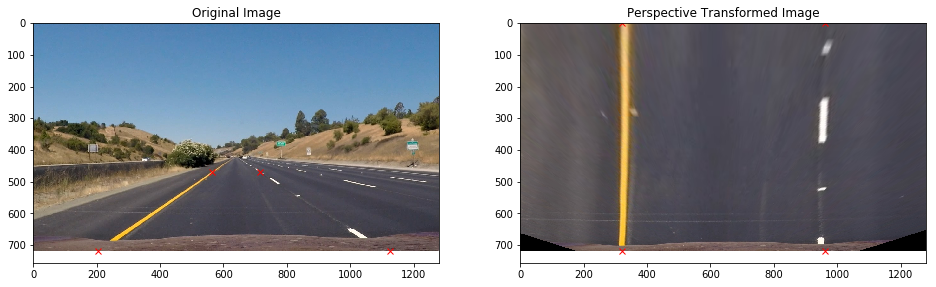

In [67]:
straightimage = mping.imread('test_images/straight_lines1.jpg')

M,Minv = perspective_transform_matrix(straightimage,show_debug=True)

In [123]:
def warpImage(img):
    img_size = img.shape[:2][::-1]
    
    M, Minv = perspective_transform_matrix(img)
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

### Lane marked Perspective Transform

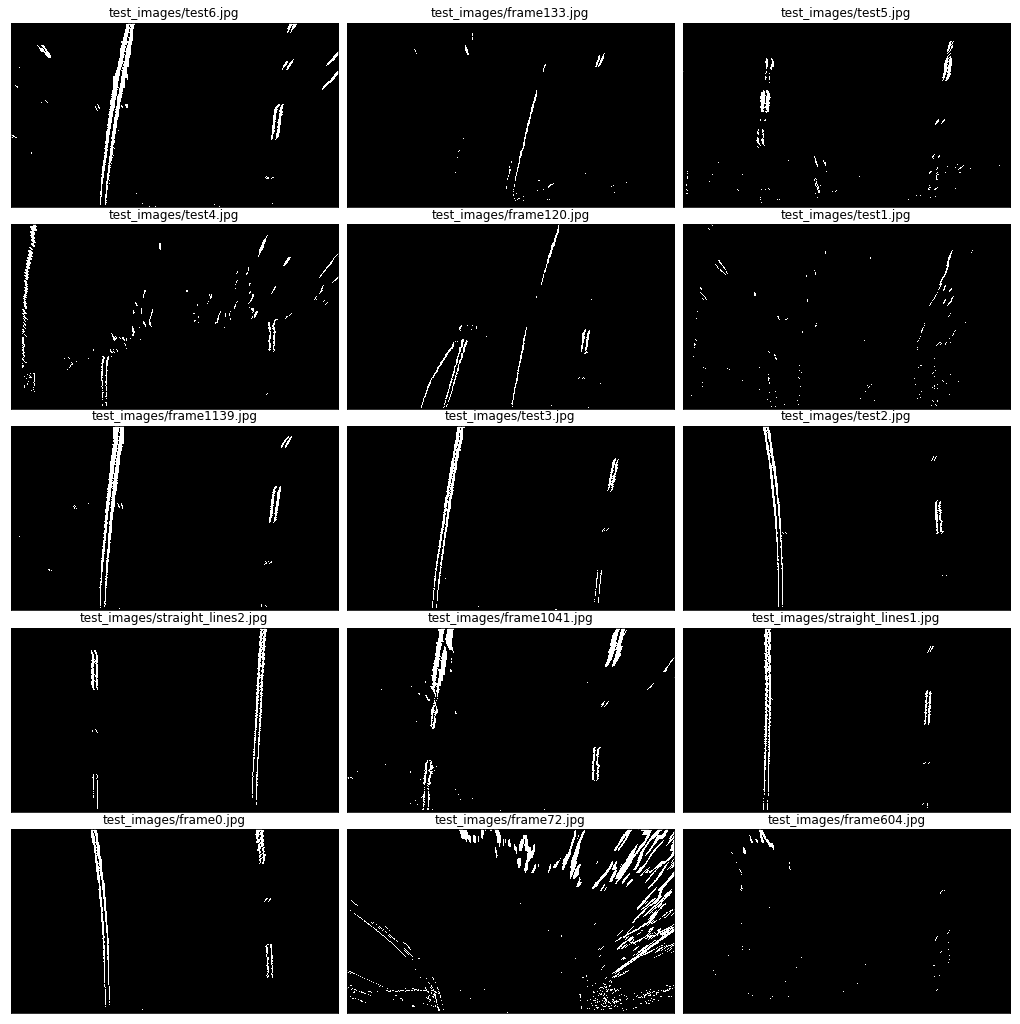

In [124]:
warped_images = list(map(warpImage, filted_binary))

showImages(warped_images, testImageList, ticksshow=False)

## <span id="jump5">Step 5: Detect lane pixels and fit to find the lane boundary.</span>

---
### Line Finding Method: Peaks in a Histogram

In [125]:
def show_histogram(binary_image):   
    histogram = np.sum(binary_image[binary_image.shape[0]//2:, :], axis=0)
    plt.plot(histogram)

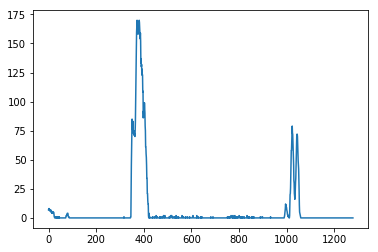

In [126]:
show_histogram(warped_images[0])

In [127]:
def fitlines(binary_warped, nwindows=9, margin=100, minpix=50, bias=0.2):
    """
    margin: Set the width of the windows +/- margin
    minpix: Set minimum number of pixels found to recenter window
    bias: left start and right start offest from middpoint
    """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    
    leftstart = int((1-bias)*midpoint)
    rightstart = int((1+bias)*midpoint)
    
    leftx_base = np.argmax(histogram[:leftstart])
    rightx_base = np.argmax(histogram[rightstart:]) + rightstart

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255] 
    
    left_fit = None
    right_fit = None
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        p_left = np.poly1d(left_fit)
        left_fitx = p_left(ploty)
        left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(left_line_pts), isClosed=False, color=(255,255,0), thickness=5)
        
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        p_right = np.poly1d(right_fit)
        right_fitx = p_right(ploty)   
        right_line_pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(right_line_pts), isClosed=False, color=(255,255,0), thickness=5)
    
    return out_img, left_fit, right_fit

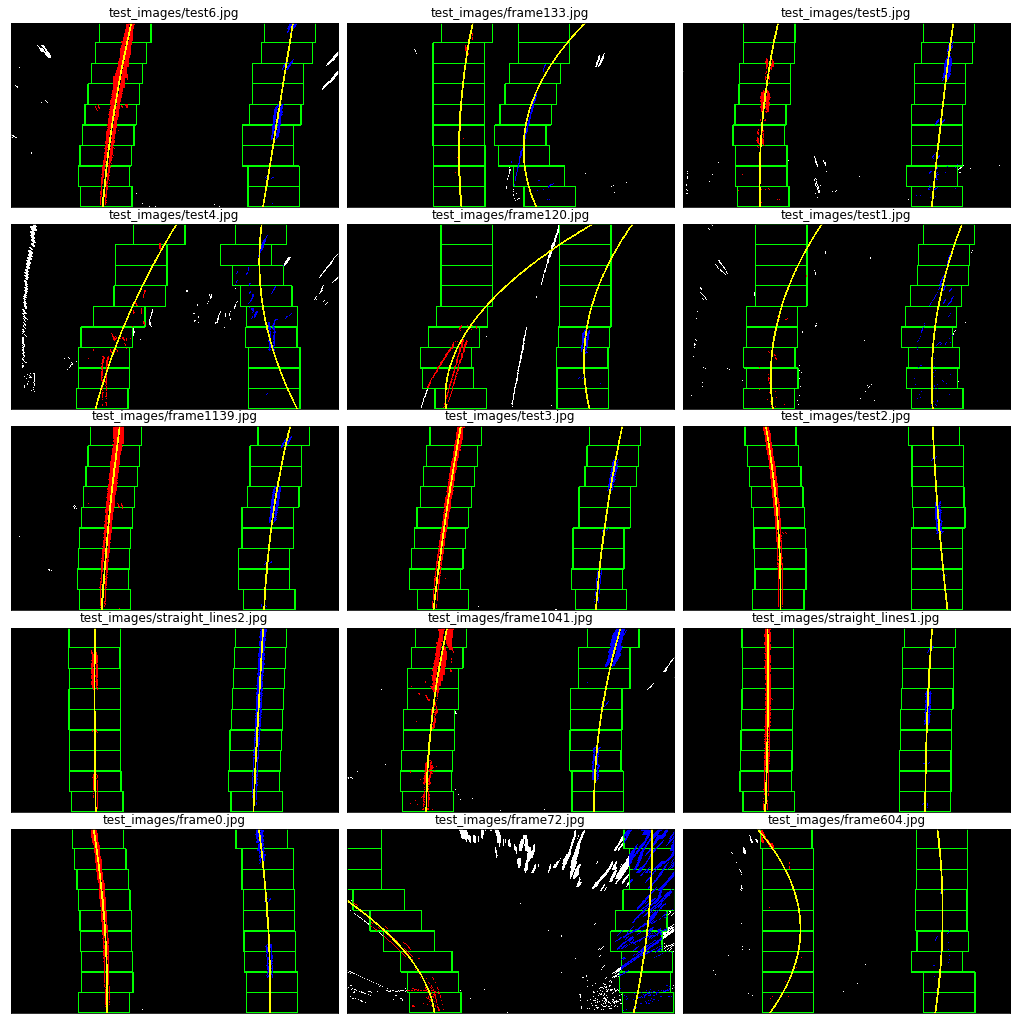

In [128]:
fitline_images = list(map(fitlines, warped_images))

fittedimges = [s[0] for s in fitline_images]
left_fits = [s[1] for s in fitline_images]
right_fits = [s[2] for s in fitline_images]

showImages(fittedimges, testImageList, ticksshow=False)

In [129]:
def fitted_lanes(binary_warped, left_fit, right_fit, margin = 100, minpix = 50):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_new_fit = None
    right_new_fit = None
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Fit a second order polynomial to each
    p_left = np.poly1d(left_fit)
    left_fitx = p_left(ploty)
        
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    
    p_right = np.poly1d(right_fit)
    right_fitx = p_right(ploty) 
        
     # Generate a polygon to illustrate the search window area
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        
    
    if len(leftx) != 0:
        left_new_fit = np.polyfit(lefty, leftx, 2)
        p_left = np.poly1d(left_new_fit)
        left_fitx = p_left(ploty)
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()

        left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(left_line_pts), isClosed=False, color=(255,255,0), thickness=5)
            
    if len(rightx) != 0:
        right_new_fit = np.polyfit(righty, rightx, 2)
        p_right = np.poly1d(right_new_fit)
        right_fitx = p_right(ploty)  
        
      
        right_line_pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(right_line_pts), isClosed=False, color=(255,255,0), thickness=5)
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result,left_new_fit,right_new_fit

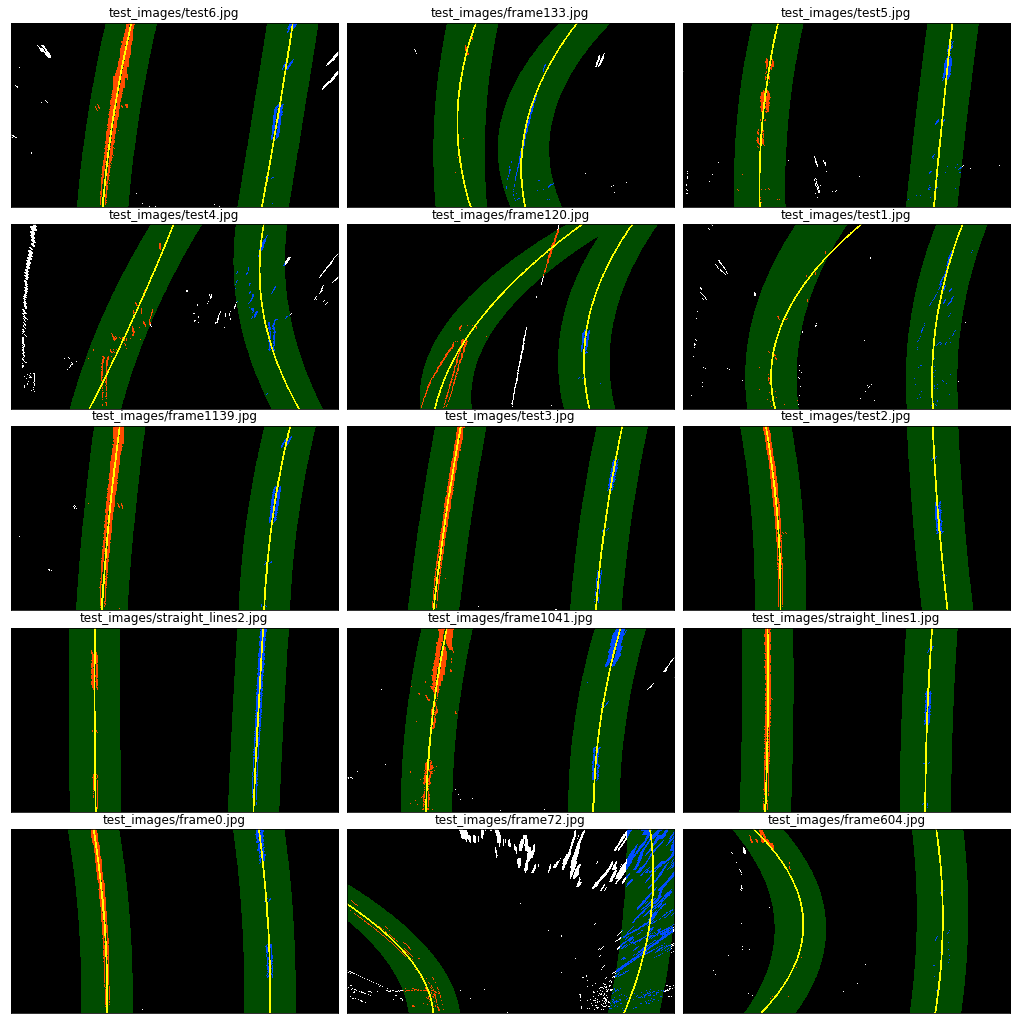

In [130]:
recogin_images = list(map(fitted_lanes, warped_images, left_fits, right_fits))

fittedimges = [s[0] for s in recogin_images]
left_fits = [s[1] for s in recogin_images]
right_fits = [s[2] for s in recogin_images]

showImages(fittedimges, testImageList, ticksshow=False)

## <span id="jump6">Setp 6: Determine the curvature of the lane and vehicle position with respect to center.</span>

---
### Measure Lane Curvature

In [131]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [132]:
def calculate_curvature(binary_warped, line_fit):

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    line_fitx = line_fit[0]*ploty**2 + line_fit[1]*ploty + line_fit[2]
    
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    line_fit_cr = np.polyfit(ploty*ym_per_pix, line_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    cal_curverad = ((1 + (2*line_fit_cr[0]*y_eval*ym_per_pix + line_fit_cr[1])**2)**1.5) / np.absolute(2*line_fit_cr[0])
    
    return cal_curverad